## Dataset 1  

Build a logistic regression classifier model to predict whether a student gets admitted into a university or not. Each applicant's chance of admission is based on their results for two exams. You are given historical data from previous applicants that you can use as a training set where each training example has the applicants scores on both exams and the previous administration's decision.  

The first thing to do is load the data and take a look at it. Before then, we should take care of all our imports and then make sure our work is reproducible by listing all software and hardware versions we're going to use.

In [1]:
# Standard data analysis
import pandas as pd
from pandas import Series,DataFrame
import numpy as np

# Standard visualization analysis
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# Scikit-learn analysis
from sklearn.cross_validation import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.grid_search import GridSearchCV

# Import division from future
from __future__ import division

# Import my own logistic regression class (see accompanying .py file)
from LogReg_Class import LogReg

# Ensure reproducibility (see accompanying rePYduce.py script)
import os
work_PATH = os.getcwd()
script_PATH = '/Users/pwinslow/DataScienceProjects/Useful_Scripts/'
os.chdir(script_PATH)
%run rePYduce.py numpy pandas matplotlib seaborn scikit-learn
os.chdir(work_PATH)


General Information...
Author: Peter Winslow
Date: Saturday March 26 2016

Python Information...
CPython: 2.7.11
IPython: 4.0.3

Module Information...
numpy 1.10.4
pandas 0.17.1
matplotlib 1.5.1
seaborn 0.7.0
scikit-learn 0.17.1

System Information...
Compiler: GCC 4.2.1 (Apple Inc. build 5577)
System: Darwin
Release: 14.0.0
Machine: x86_64
Processor: i386
CPU Cores: 4
Interpreter: 64bit


Now let's take a look at the data

In [2]:
exam_df = pd.read_csv('ex2data1.txt', header = None)
exam_df.columns = ['score1', 'score2', 'admitted']
exam_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 0 to 99
Data columns (total 3 columns):
score1      100 non-null float64
score2      100 non-null float64
admitted    100 non-null int64
dtypes: float64(2), int64(1)
memory usage: 3.1 KB


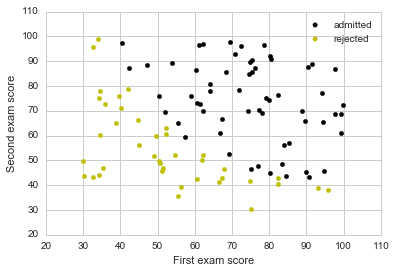

In [3]:
# Plot the two data sets (admitted and not admitted) to see how they compare in terms of exam scores
def plotdata(df):
    
    input1, input2 = df.columns[0:-1]
    class_colname = df.columns[-1]
    
    ax = plt.subplot(111)
    
    # Note: this assumes that the df has been formatted so that the two classes are defined as '0' or '1'
    
    plt.scatter(df[df[class_colname] == 1][input1], 
            df[df[class_colname] == 1][input2], 
            color = 'black')
    
    plt.scatter(df[df[class_colname] == 0][input1], 
            df[df[class_colname] == 0][input2], 
            color = 'y')
    
    return ax

ax = plotdata(exam_df)
plt.legend(['admitted', 'rejected'])
plt.xlabel('First exam score')
plt.ylabel('Second exam score')

It looks like a linear decision boundary should suffice here.   

First, prepare the data for training.

In [4]:
# Extract design matrix and target vector
X = exam_df[['score1', 'score2']].values
Y = exam_df['admitted'].values
m, n = X.shape
# Add bias column to design matrix
X = np.insert(X, 0, np.ones(X.shape[0]), axis = 1)

### My logistic regression classifier  

I'll begin by performing a quick and dirty analysis of the dataset with my own imported logistic regression class. I initiate an instance of the class, train the model on the data to extract the regression parameters, and evaluate the model based on its accuracy score.

In [5]:
# Perform an initial analysis using the entire dataset for training
initial_theta = np.zeros( X.shape[1] )
logreg_classifier = LogReg()
theta_best = logreg_classifier.fit(initial_theta, X, Y)
score = logreg_classifier.score(theta_best, X, Y)
print 'Best fit regression parameters: {0}'.format(theta_best)
print 'Accuracy score: {0}'.format(score)

Best fit regression parameters: [-25.16159955   0.20623317   0.20147445]
Accuracy score: 0.89


We should now ask: is 89% accuracy really a good representation of the accuracy we should expect if we were to apply our fitted model to new data? In the code above, we train and test the model on the same (entire) dataset. This leaves us open to the possibility that we may be overfitting the data, i.e., fitting not just to feature trends and general behaviours but also to the statistical noise. If true the model will fail, to some extent (depending on how highly the fitting procedure weighted the noise), to accurately predict anything useful on new unseen data.  

To obtain a better estimate of the accuracy of the model we use a stratified k-fold cross validation of the data. A k-fold cross validation approach splits the dataset into k parts. One part is used to test the model while the amalgamation of the other k-1 parts are used to train it. We then repeat this process k times, each time using a different part of the split data as the test set. A stratified k-fold cross validation is a very similar procedure with the crucial difference that the global percentage of samples of each class is preserved in each of the k folds. This is necessary as a random split of the data could accidentally lead to a training sample with no examples of a certain class, leading to a horrible accuracy on a test sample containing many of these examples.   

We implement a stratified 10-fold cross validation below, evaluating the score achieved on each test set and taking the average as the actual score for the model.

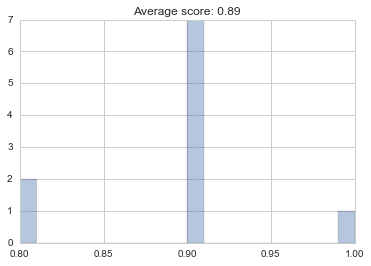

In [6]:
# Implement a stratified split of the data into train and test sets
skf = StratifiedKFold(Y, n_folds=10)

# Loop through folds, collecting accuracies as you go
scores = []
thetas = []
for train_index, test_index in skf:
    
    # Split inputs and targets
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    initial_theta = np.zeros( X_train.shape[1] )

    # Create an instance of the logistic regression classifier
    logreg_classifier = LogReg()

    # Determine best fit parameters
    theta_best = logreg_classifier.fit(initial_theta, X_train, Y_train)
    thetas.append(theta_best)

    # Determine accuracy based on best fit parameters
    scores.append(logreg_classifier.score(theta_best, X_test, Y_test))
    
# Calculate the average score for the model based on all 10 scores
avg_score = np.mean(scores)
# Calculate the average regression parameters
avg_thetas = np.mean(thetas, axis = 0)

# Plot a histogram of the scores
sns.distplot(scores, bins = 20, kde = False)
plt.title('Average score: {}'.format(avg_score))

In this case, it turned out that the model was not suffering from overfitting. From the average regression parameters, we can plot the corresponding decision boundary

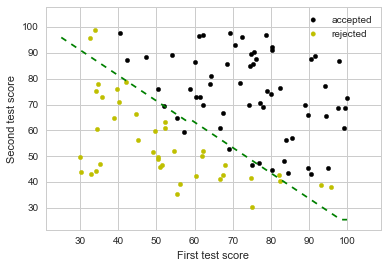

In [7]:
# Create an instance of the logistic regression classifier
logreg_classifier = LogReg()

# Define a mesh for a contour plot of the decision boundary
x_min, x_max = X[:,1].min()-5, X[:,1].max()+5
y_min, y_max = X[:,2].min()-5, X[:,2].max()+5
contour_x = np.linspace(x_min, x_max)
contour_y = np.linspace(y_min, y_max)

# Define a function which returns the model class prediction for a given set of inputs and the average regression
# parameters obtained from the 10-fold cross validation
def calc_z(x,y):
    return logreg_classifier.predict(avg_thetas, np.array([1, x, y]))

# Calculate the class prediction for each point in the mesh
z = np.zeros((len(contour_x), len(contour_y)))
for i, c_x in enumerate(contour_x):
    for j, c_y in enumerate(contour_y):
        z[i,j] = calc_z(c_x, c_y)

# Plot original data and decision boundary contour on top 
ax = plotdata(exam_df)
ax.contour(contour_x, contour_y, z, levels = [0], colors='green', linestyles = ['dashed'])
plt.legend(['accepted', 'rejected'])
plt.xlabel('First test score')
plt.ylabel('Second test score')

### Scikit-learn logistic regression classifier   

Now we'll take a look at scikit-learn's implementation of logistic regression. We'll just skip straight to the 10-fold stratified cross validation.

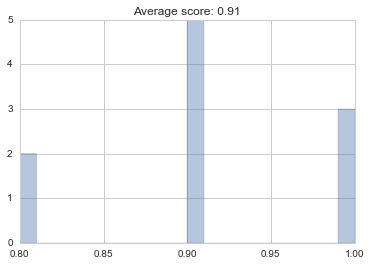

In [8]:
# Implement a stratified split of the data into train and test sets
skf = StratifiedKFold(Y, n_folds=10)

# Loop through folds, collecting accuracies as you go
scores = []
thetas = []
for train_index, test_index in skf:
    
    # Split inputs and targets
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]

    # Create an instance of the logistic regression classifier
    logreg_classifier = LogisticRegression()

    # Fit the model
    logreg_classifier.fit(X_train, Y_train)

    # Determine accuracy based on best fit parameters
    # Predict the classes of the test set
    predict_classes = logreg_classifier.predict(X_test)
    thetas.append(logreg_classifier.coef_.ravel())
    scores.append(metrics.accuracy_score(Y_test, predict_classes))
    
# Calculate the average score for the model based on all 10 scores
avg_score = np.mean(scores)
# Calculate the average regression parameters
avg_thetas = np.mean(thetas, axis = 0)

# Plot a histogram of the scores
sns.distplot(scores, bins = 20, kde = False)
plt.title('Average score: {}'.format(avg_score))

This does have a slightly higher accuracy, i.e., a higher average and more folds leading to a ~100% accuracy. We can plot the decision boundary for this now. In order to obtain the classifier associated with the average score (91%), we have to run the 10-fold stratified cross validation again but jump out of the loop once we've got that one.

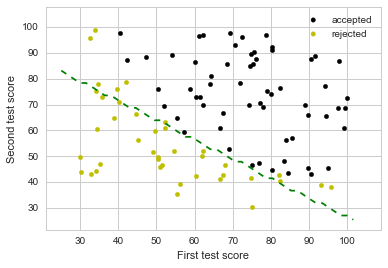

In [9]:
# Implement a stratified split of the data into train and test sets
skf = StratifiedKFold(Y, n_folds=10)
for train_index, test_index in skf:
    
    # Split inputs and targets
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    initial_theta = np.zeros( X_train.shape[1] )

    # Create an instance of the logistic regression classifier
    logreg_classifier = LogisticRegression()

    # Fit the model
    logreg_classifier.fit(X_train, Y_train)

    # Determine accuracy based on best fit parameters
    # Predict the classes of the test set
    predict_classes = logreg_classifier.predict(X_test)
    score = metrics.accuracy_score(Y_test, predict_classes)
    
    # Break out of the loop if the average score is obtained
    if .85 <= score <= .95:
        break
        
# Plot decision boundary

x_min, x_max = X[:,1].min()-5, X[:,1].max()+5
y_min, y_max = X[:,2].min()-5, X[:,2].max()+5
contour_x = np.linspace(x_min, x_max)
contour_y = np.linspace(y_min, y_max)

def calc_z(x,y):
    return logreg_classifier.predict(np.array([[1, x, y]]))

z = np.zeros((len(contour_x), len(contour_y)))
for i, c_x in enumerate(contour_x):
    for j, c_y in enumerate(contour_y):
        z[i,j] = calc_z(c_x, c_y)

ax = plotdata(exam_df)
ax.contour(contour_x, contour_y, z, levels = [0], colors='green', linestyles = ['dashed'])
plt.legend(['accepted', 'rejected'])
plt.xlabel('First test score')
plt.ylabel('Second test score')

This is great but it's somewhat limited by the fact that the regression model is based on a linear data which is unable to make use of perhaps a more suitable polynomial fit. Even in the previous plot, we can see that we may benefit slightly from some polynomial features.   

To compare the performance of mine and scikit-learn's logistic regression classifiers on a dataset with polynomial features, we can consider the following dataset.

## Dataset 2  

Build a logistic regression classifier model to predict whether microchips from a fabrication plant pass quality assurance or not. During quality assurance, each chip goes through various tests to ensure it is functioning properly. You are given test results for two separate tests. From these two tests, you want to determine which chips should be accepted and which should be rejected. You are also given data on test results of past microchips to train a regression model.

First, let's take a look at the data

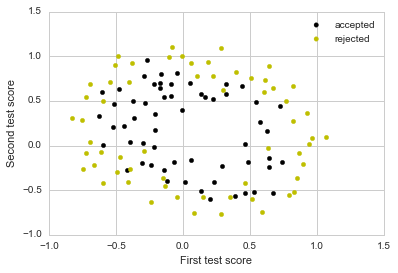

In [10]:
# Upload the data
exam_df = pd.read_csv('ex2data2.txt', header = None)
exam_df.columns = ['score1', 'score2', 'accepted']

# Translate data into numpy arrays
X = exam_df[['score1', 'score2']].values
Y = exam_df['accepted'].values

# Plot the data
ax = plotdata(exam_df)
plt.legend(['accepted', 'rejected'])
plt.xlabel('First test score')
plt.ylabel('Second test score')

### My logistic regression classifier  

Before training, we need to expand the dataset to encapsulate polynomial values of the two exam scores. We'll just start with a stratified 10-fold cross validation.

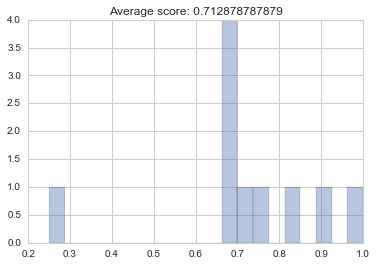

In [11]:
# Use the poly_map method of the LogReg class to map to polynomial values and insert the bias feature. Try a 6 degree
# polynomial mapping.
logreg_classifier = LogReg()
X_poly = logreg_classifier.poly_map(X[:,0], X[:,1], 6)

# Implement a stratified split of the data into train and test sets
skf = StratifiedKFold(Y, n_folds=10)

# Loop through folds, collecting accuracies as you go
scores = []
thetas = []
for train_index, test_index in skf:
    
    # Split inputs and targets
    X_train, X_test = X_poly[train_index], X_poly[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    initial_theta = np.zeros( X_train.shape[1] )

    # Create an instance of the logistic regression classifier. From trial-and-error, we learn that we require 
    # a non-zero value of the ridge regression parameter to avoid overfitting the data with each instance and 
    # ending up with completely unrealistic fit parameters. 
    logreg_classifier = LogReg(lmbda=1, threshold=.5)

    # Determine best fit parameters
    theta_best = logreg_classifier.fit(initial_theta, X_train, Y_train)
    thetas.append(theta_best)

    # Determine accuracy based on best fit parameters
    scores.append(logreg_classifier.score(theta_best, X_test, Y_test))
    
    
# Calculate the average score for the model based on all 10 scores
avg_score = np.mean(scores)
# Calculate the average regression parameters
avg_thetas = np.mean(thetas, axis = 0)

# Plot a histogram of the scores
sns.distplot(scores, bins = 20, kde = False)
plt.title('Average score: {}'.format(avg_score))

Use the average regression parameters to visualize the decision boundary.

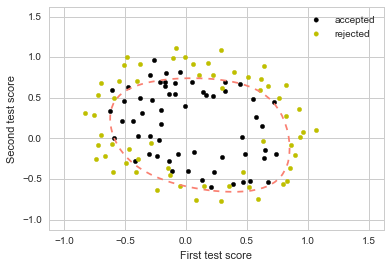

In [12]:
# What does the resulting decision boundary look like?
contour_x = np.linspace(-1, 1.5)
contour_y = np.linspace(-1, 1.5)

def calc_z(x,y):
    return logreg_classifier.poly_map(x, y, 6).dot(avg_thetas)

z = np.zeros((len(contour_x), len(contour_y)))
for i, c_x in enumerate(contour_x):
    for j, c_y in enumerate(contour_y):
        z[i,j] = calc_z(c_x, c_y)

ax = plotdata(exam_df)
ax.contour(contour_x, contour_y, z, levels = [0], colors='salmon', linestyles = ['dashed'])
plt.legend(['accepted', 'rejected'])
plt.xlabel('First test score')
plt.ylabel('Second test score')

This decision boundary was derived assuming certain values for the model parameters. One other way we may optimize our model is to find the model parameter values that maximize the accuracy score. For this, we perform a grid_search which calculates the score for a range of values of all model parameters and returns the highest scoring combination of parameters.

In [13]:
# Define a parameter grid to scan over
import itertools as it
param_grid = {'lambda':[.75, .8, .9, 1, 3, 5, 10], 'threshold':[.35,.4,.5,.6,.7,.8,.9], 
              'poly_degree':[2,3,4,5,6,7,8,9,10]}
varNames = sorted(param_grid)
val_combos = [dict(zip(varNames, prod)) for prod in it.product(*(param_grid[varName] for varName in varNames))]

# Implement a stratified split of the data into train and test sets before entering grid search
skf = StratifiedKFold(Y, n_folds=10)
    
score_results = []
for combo in val_combos:
    
    logreg_classifier = LogReg(lmbda = combo['lambda'], threshold = combo['threshold'])
    X_poly = logreg_classifier.poly_map(X[:,0], X[:,1], combo['poly_degree'])
    
    scores = []
    for train_index, test_index in skf:
    
        # Split inputs and targets
        X_train, X_test = X_poly[train_index], X_poly[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        initial_theta = np.zeros( X_train.shape[1] )

        # Determine best fit parameters
        theta_best = logreg_classifier.fit(initial_theta, X_train, Y_train)

        # Determine accuracy based on best fit parameters
        scores.append(logreg_classifier.score(theta_best, X_test, Y_test))
    
    avg_score = np.mean(scores)
    
    score_results.append([combo['lambda'], combo['threshold'], combo['poly_degree'], avg_score])


# Collect overall results
score_results = np.array(score_results)
max_index = score_results[:,3].argmax()
best_lambda, best_threshold, best_poly_degree, best_score = score_results[max_index]

# Print results of scan
print 'lambda_best: {0}, threshold_best: {1}, poly_degree_best: {2}, best score: {3}'.format(best_lambda, 
                                                                                            best_threshold, 
                                                                                            best_poly_degree, 
                                                                                            best_score)

lambda_best: 0.75, threshold_best: 0.5, poly_degree_best: 2.0, best score: 0.72803030303


The best score is actually not so far away from the one we got from our original parameter choice. We now recalculate the decision boundary based on the optimized classifier with the best parameters

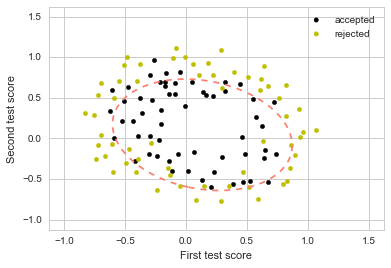

In [14]:
# Implement a stratified split of the data into train and test sets
skf = StratifiedKFold(Y, n_folds=10)

# Loop through folds, collecting accuracies as you go
scores = []
thetas = []
for train_index, test_index in skf:
    
    # Initialize an instance of the optimized classifier and polynomial expansion of the dataset
    logreg_classifier = LogReg(lmbda=best_lambda, threshold=best_threshold)
    X_poly = logreg_classifier.poly_map(X[:,0], X[:,1], best_poly_degree)

    # Split inputs and targets
    X_train, X_test = X_poly[train_index], X_poly[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    initial_theta = np.zeros( X_train.shape[1] )

    # Determine best fit parameters
    theta_best = logreg_classifier.fit(initial_theta, X_train, Y_train)
    thetas.append(theta_best)

    # Determine accuracy based on best fit parameters
    scores.append(logreg_classifier.score(theta_best, X_test, Y_test))
    
    
# Calculate the average regression parameters
avg_thetas = np.mean(thetas, axis = 0)

# Plot decision boundary
contour_x = np.linspace(-1, 1.5)
contour_y = np.linspace(-1, 1.5)

def calc_z(x,y):
    return logreg_classifier.poly_map(x, y, best_poly_degree).dot(avg_thetas)

z = np.zeros((len(contour_x), len(contour_y)))
for i, c_x in enumerate(contour_x):
    for j, c_y in enumerate(contour_y):
        z[i,j] = calc_z(c_x, c_y)

ax = plotdata(exam_df)
ax.contour(contour_x, contour_y, z, levels = [0], colors='salmon', linestyles = ['dashed'])
plt.legend(['accepted', 'rejected'])
plt.xlabel('First test score')
plt.ylabel('Second test score')

### Scikit-learn logistic regression classifier   

Now we'll take a look at scikit-learn's implementation of logistic regression. We'll just skip straight to a grid search for the regularization parameter using a 10-fold stratified cross validation.

In [15]:
# We'll still use the poly_map method of the LogReg class to map to polynomial values and insert the bias feature.
# Since GridSearchCV doesn't take this parameter as an internal one, we'll need to modify it by hand, looking for the 
# best score.
logreg_classifier = LogReg()
X_poly = logreg_classifier.poly_map(X[:,0], X[:,1], 2)

logreg_classifier = LogisticRegression()

parameter_grid = {'C':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]}

cross_validation = StratifiedKFold(Y, n_folds = 10)

grid_search = GridSearchCV(logreg_classifier, param_grid = parameter_grid, cv = cross_validation)

grid_search.fit(X_poly, Y)

print 'Best score: {}'.format(grid_search.best_score_)
print 'Best ridge regression parameter: {}'.format(grid_search.best_params_['C'])

grid_search.best_estimator_

Best score: 0.762711864407
Best ridge regression parameter: 5


LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

This classifier does indeed do better than my own. Using the best estimator, we can now draw the decision boundary.

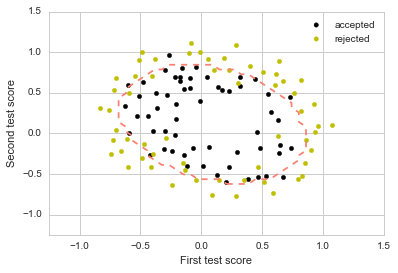

In [16]:
my_classifier = LogReg()
X_poly = my_classifier.poly_map(X[:,0], X[:,1], 2)

# Plot decision boundary
x_min, x_max = X_poly[:,1].min()-.5, X_poly[:,1].max()+.5
y_min, y_max = X_poly[:,2].min()-.5, X_poly[:,2].max()+.5
contour_x = np.linspace(x_min, x_max)
contour_y = np.linspace(y_min, y_max)

def calc_z(x,y):
    return grid_search.best_estimator_.predict([my_classifier.poly_map(x, y, 2)])

z = np.zeros((len(contour_x), len(contour_y)))
for i, c_x in enumerate(contour_x):
    for j, c_y in enumerate(contour_y):
        z[i,j] = calc_z(c_x, c_y)

ax = plotdata(exam_df)
ax.contour(contour_x, contour_y, z, levels = [0], colors='salmon', linestyles = ['dashed'])
plt.legend(['accepted', 'rejected'])
plt.xlim(-1.25, 1.5)
plt.ylim(-1.25, 1.5)
plt.xlabel('First test score')
plt.ylabel('Second test score')

# Conclusions (so far...):  

- For data with both linear and polynomial features, the scikit-learn classifier consistently performs better than my classifier.  
- It only outperforms my classifier by a few percent in each case though. I may be able to improve my performance by using a different optimization algorithm in the LogReg class.